In [1]:
import pickle
from datetime import datetime
from collections import defaultdict
import rpy2
import pandas as pd
import matplotlib.pyplot as plt
from django.db.models.functions import TruncDay
from pathlib import Path
import pytz
import numpy as np
import seaborn as sns

In [2]:
%load_ext rpy2.ipython

In [3]:
folder = "data/comp1_2020_1/"
Path(folder).mkdir(parents=True, exist_ok=True)

### Get student list

In [4]:
with open("%s/userlogs.pkl" % folder, "rb") as pklfile:
    userlogs = pickle.load(pklfile)

In [5]:
userlogs[0]

{'user__id': 912,
 'problem__id': 838,
 'outcome': 'P',
 'timestamp': datetime.datetime(2020, 12, 7, 17, 13, 38, 320643, tzinfo=<UTC>),
 'user__userprofile__user_class': 30,
 'problem__chapter': 20}

In [6]:
students_list = list(set([log['user__id'] for log in userlogs]))
problems_list = list(set([log['problem__id'] for log in userlogs]))
classes_list = list(set([log['user__userprofile__user_class'] for log in userlogs]))
chapters_list = list(set([log['problem__chapter'] for log in userlogs]))

print(f"Total de alunos: {len(students_list)}")
print(f"Total de problemas: {len(problems_list)}")
print(f"Total de turmas: {len(classes_list)}")
print(f"Total de listas: {len(chapters_list)}")

Total de alunos: 427
Total de problemas: 50
Total de turmas: 15
Total de listas: 9


### Calculate drop-out rate and students submission per week

#### Organize chapter and weeks

In [7]:
c = Chapter.objects.filter(pk__in=chapters_list).values('pk', 'label')
for item in c:
    print(f"{item['pk']} - {item['label']}")

10 - 10 - Dicionário
19 - (PLE) 09 - Laços aninhados e matrizes
20 - (PLE) 02 - Funcoes e Tipos de dados
12 - (PLE) 03 - Tipos de dados, Strings, Estrutura Condicional
13 - (PLE) 04 - Variáveis e atribuição, strings e tuplas
14 - (PLE) 05 - Manipulação de strings, tuplas e listas
15 - (PLE) 06 - Fatiamento e manipulação de listas
16 - (PLE) 07 - Estrutura de repetição com teste de parada: While
17 - (PLE) 08 - Estrutura de repetição iteradora: for


In [8]:
from django.db.models import Case, When

chapter_order = [20, 12, 13, 14, 15, 16, 17, 19, 10]
preserved = Case(*[When(pk=pk, then=pos) for pos, pk in enumerate(chapter_order)])
chapters = Chapter.objects.filter(pk__in=chapter_order).order_by(preserved)

chapter_dict = {}
chapter_start = 2
for idx, item in enumerate(chapters):
    chapter_dict[idx+chapter_start] = item.pk
    print(f"{item.pk} - {item.label}")

20 - (PLE) 02 - Funcoes e Tipos de dados
12 - (PLE) 03 - Tipos de dados, Strings, Estrutura Condicional
13 - (PLE) 04 - Variáveis e atribuição, strings e tuplas
14 - (PLE) 05 - Manipulação de strings, tuplas e listas
15 - (PLE) 06 - Fatiamento e manipulação de listas
16 - (PLE) 07 - Estrutura de repetição com teste de parada: While
17 - (PLE) 08 - Estrutura de repetição iteradora: for
19 - (PLE) 09 - Laços aninhados e matrizes
10 - 10 - Dicionário


In [9]:
def get_chapters(chapters, weeks):
    result = []
    for item in weeks:
        result.append(chapters[item])
    return result

#### Set log query valid dates

In [14]:
students_count = []
data_inicio = datetime.strptime('30/11/2020 00:00:00', '%d/%m/%Y %H:%M:%S')
data_inicio = pytz.timezone("America/Sao_Paulo").localize(data_inicio, is_dst=None)
data_fim = datetime.strptime('06/03/2021 23:59:59', '%d/%m/%Y %H:%M:%S')
data_fim = pytz.timezone("America/Sao_Paulo").localize(data_fim, is_dst=None)

userlog_queryset = UserLog.objects.filter(timestamp__gte=data_inicio, timestamp__lte=data_fim, 
                                          user_id__in=students_list, 
                                          problem__chapter__in=chapters_list)
userlog_queryset.count()

107701

In [15]:
# Count students per week
students_count = []
for c in chapters:
    problems = Problem.objects.filter(chapter=c)
    students = userlog_queryset.filter(problem__in=problems
                                              ).order_by('timestamp'
                                                        ).values_list('user_id', flat=True
                                                                     ).order_by('user_id').distinct()
    students_count.append(students.count())
    
    
# Get students that finished  the last exercises
LAST = [9, 10]
chapter_filter = get_chapters(chapter_dict, LAST)
students = userlog_queryset.filter(problem__chapter__in=chapter_filter
                                              ).order_by('timestamp'
                                                        ).values_list('user_id', flat=True
                                                                     ).order_by('user_id').distinct()
print("Students that submitted in the last 2 weeks: %d" % students.count())

# Get students that finished  the last exercises
LAST = [8, 9, 10]
chapter_filter = get_chapters(chapter_dict, LAST)
students = userlog_queryset.filter(problem__chapter__in=chapter_filter
                                              ).order_by('timestamp'
                                                        ).values_list('user_id', flat=True
                                                                     ).order_by('user_id').distinct()
print("Students that submitted in the last 3 weeks: %d" % students.count())

Students that submitted in the last 2 weeks: 321
Students that submitted in the last 3 weeks: 338


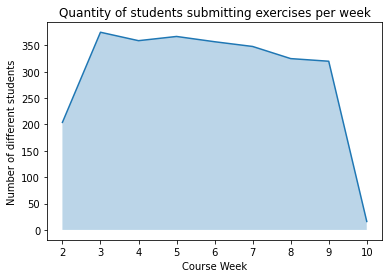

In [12]:
# plt.figure(figsize=(5,4))
plt.plot(range(chapter_start, len(chapter_dict)+chapter_start), students_count)
plt.title("Quantity of students submitting exercises per week")
plt.xlabel("Course Week")
plt.ylabel("Number of different students")
plt.fill_between(range(chapter_start, len(chapter_dict)+chapter_start), students_count, alpha=0.3)
plt.savefig("%s/dropout_rate.png" % folder)
plt.show()

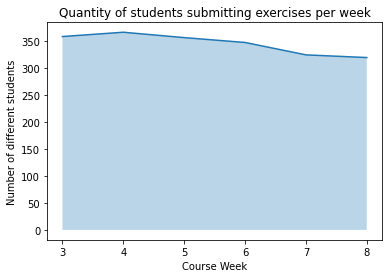

In [13]:
# plt.figure(figsize=(5,4))
plt.plot(range(3, 9), students_count[2:-1])
plt.title("Quantity of students submitting exercises per week")
plt.xlabel("Course Week")
plt.ylabel("Number of different students")
plt.fill_between(range(3, 9), students_count[2:-1], alpha=0.3)
plt.savefig("%s/dropout_rate.png" % folder)
plt.show()

In [14]:
students_count

[204, 375, 359, 367, 357, 348, 325, 320, 16]

In [15]:
%%R
cor.test(c(3:9), c(375, 359, 367, 357, 348, 325, 320))


	Pearson's product-moment correlation

data:  c(3:9) and c(375, 359, 367, 357, 348, 325, 320)
t = -6.099, df = 5, p-value = 0.001716
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9911594 -0.6343112
sample estimates:
       cor 
-0.9388878 



### Features per week

Parameters:
1. Quanto tempo conta para contar como "tentativas"? Até acertar a primeira?
2. 

In [16]:
def get_deadline(outcomes):
    deadline = Deadline.objects.filter(
            onlineclass=outcomes[0].user.userprofile.user_class, chapter=chapter
        ).order_by('-deadline')
    if deadline.count():
        return deadline[0].deadline
    else:
        raise RuntimeError("Chapter does not have deadline")
        
def get_time_to_solution(attempts_queryset):
    total = attempts_queryset.count()
    time_to_solution = attempts_queryset[total-1].timestamp - attempts_queryset[0].timestamp
    return time_to_solution.total_seconds()

def get_on_time_exercises(deadline, attempts_queryset):
    total = attempts_queryset.count()
    if attempts_queryset[total-1].timestamp < deadline:
        return 1
    return 0

In [ ]:
%%time

# Using 1st two weeks with student (3 and 4)
data_per_week = defaultdict(dict)
CHAPTERS = [3, 4, 5,6, 8, 9]
chapter_filter = get_chapters(chapter_dict, CHAPTERS)

# For each student
for student in students_list:
#     print(f"student {student}")
    # For each week
    for chapter in chapter_filter:
#         print(f"chapter {chapter}")
        
        # Create features
        attempts = 0
        success_count = 0
        timedelta_to_solution = 0
        timedelta_from_beginning = 0
        on_time_exercises = 0
        
        outcomes = userlog_queryset.filter(user_id=student, 
                                           problem__chapter=chapter
                                          ).order_by('timestamp')
        
        if outcomes.count():
            # Get chapter deadline
            try:
                deadline = get_deadline(outcomes)
            except RuntimeError:
                print(f"Cant find deadline for chapter {chapter} for class {outcomes[0].user.userprofile.user_class}")
    #         print(f"deadline {deadline}")

            # Get timestamp of success
            outcomes_success = outcomes.filter(outcome='P').order_by('problem', 'timestamp')

            # For each correct problem, get number of attempts before success
            if outcomes_success.count():
                current_problem = 0
                for success in outcomes_success:
    #                 print(f"problem {success.problem}")
                    if success.problem != current_problem:
                        attempts_queryset = outcomes.filter(problem=success.problem, timestamp__lte=success.timestamp)

                        # Get attempts statistics
                        problem_attempts = attempts_queryset.count()
                        attempts += problem_attempts
                        success_count += 1
                        timedelta_to_solution += get_time_to_solution(attempts_queryset)
                        timedelta_from_beginning += get_time_to_solution(attempts_queryset) + attempts_queryset[0].seconds_in_page
                        on_time_exercises += get_on_time_exercises(deadline, attempts_queryset)

    #                     print(f"attempts {attempts}")
    #                     print(f"timedelta_to_solution {timedelta_to_solution}")
    #                     print(f"timedelta_from_beginning {timedelta_from_beginning}")
                        current_problem = success.problem
                    else:
                        pass
    #                     print(f"skipping problem {success.problem}")

            # For each wrong problem, just sum failed attempts that were done before deadline
            correct_problems = outcomes_success.values_list('problem', flat=True)
            outcomes_fail = outcomes.filter(timestamp__lte=deadline).exclude(problem__in=correct_problems)

            if outcomes_fail.count():
                print(f"student {student} presented fail outcome")
                attempts += outcomes_fail.count()

        # Get access frequency
        frequency = outcomes.annotate(day=TruncDay('timestamp')
                                     ).values('day').order_by('day').distinct().count()

        data_per_week[student].update({
            f"attempts_{chapter}": attempts,
            f"success_rate_{chapter}": np.float64(success_count)/attempts,
            f"avg_timedelta_to_solution_{chapter}": np.float64(timedelta_to_solution)/success_count,
            f"avg_timedelta_from_beginning_{chapter}": np.float64(timedelta_from_beginning)/success_count,
            f"on_time_exercises_{chapter}": on_time_exercises,
            f"frequency_{chapter}": frequency,
            f"success_count_{chapter}": success_count
        })

student 915 presented fail outcome
student 915 presented fail outcome


In [18]:
len(data_per_week)

427

In [20]:
# with open(f'{folder}/dropout_data_per_week_dict.pkl', 'wb') as pklfile:
#     pickle.dump(data_per_week, pklfile)

In [10]:
with open(f'{folder}/dropout_data_per_week_dict.pkl', 'rb') as pklfile:
    data_per_week = pickle.load(pklfile)

In [14]:
data_per_week.

AttributeError: 'collections.defaultdict' object has no attribute 'columns'

### Total features

In [23]:
%%time

# Using 1st two weeks with student (3 and 4)
data_total = defaultdict(dict)
FIRST = [3, 4]
chapter_filter = get_chapters(chapter_dict, FIRST)

# For each student
for student in students_list:
#     print(f"student {student}")

    # Create features
    data_total[student] = {
        "attempts": 0,
        "success_rate": 0,
        "avg_timedelta_to_solution": 0,
        "avg_timedelta_from_beginning": 0,
        "on_time_exercises": 0,
        "frequency": 0,
        "success_count": 0
    }
    
    attempts = 0
    success_count = 0
    timedelta_to_solution = 0
    timedelta_from_beginning = 0
    on_time_exercises = 0

    outcomes = userlog_queryset.filter(user_id=student, 
                                       problem__chapter__in=chapter_filter
                                      ).order_by('timestamp')
            
    # Get access frequency
    data_total[student]["frequency"] = outcomes.annotate(day=TruncDay('timestamp')
                                 ).values('day').order_by('day').distinct().count()
    
    for chapter in chapter_filter:
        # Sum weekly feature to get total features
        data_total[student]['attempts'] += data_per_week[student][f"attempts_{chapter}"]
        data_total[student]['success_count'] += data_per_week[student][f"success_count_{chapter}"]
        data_total[student]['on_time_exercises'] += data_per_week[student][f"on_time_exercises_{chapter}"]

        # Recalculate avg values for total features
        data_total[student]['avg_timedelta_to_solution'] += data_per_week[
            student][f"avg_timedelta_to_solution_{chapter}"] * data_per_week[student][f"success_count_{chapter}"]
        data_total[student]['avg_timedelta_from_beginning'] += data_per_week[
            student][f"avg_timedelta_from_beginning_{chapter}"] * data_per_week[student][f"success_count_{chapter}"]
        
#     data_total[student]['total_to_solution'] = data_total[student]['avg_timedelta_to_solution']
#     data_total[student]['total_from_beginning'] = data_total[student]['avg_timedelta_from_beginning']
    data_total[student]['success_rate'] = np.float64(data_total[student]["success_count"])/data_total[student]["attempts"]
    data_total[student]['avg_timedelta_to_solution'] /= data_total[student]["success_count"]
    data_total[student]['avg_timedelta_from_beginning'] /= data_total[student]["success_count"]
#     break    

<timed exec>:49: RuntimeWarning: invalid value encountered in double_scalars


CPU times: user 1.36 s, sys: 30.7 ms, total: 1.39 s
Wall time: 58.5 s


In [24]:
from copy import deepcopy
data_total_and_per_week = deepcopy(data_per_week)

In [25]:
for student in data_total_and_per_week.keys():
    data_total_and_per_week[student].update(data_total[student])

In [26]:
# df_per_week = pd.DataFrame.from_dict(data_per_week, orient='index')
# df_total = pd.DataFrame.from_dict(data_total, orient='index')
df_total_and_per_week = pd.DataFrame.from_dict(data_total_and_per_week, orient='index')

In [28]:
with open(f'{folder}/dropout_df_total_and_per_week_dict.pkl', 'wb') as pklfile:
#     pickle.dump(df_total_and_per_week, pklfile)

In [11]:
with open(f'{folder}/dropout_df_total_and_per_week_dict.pkl', 'rb') as pklfile:
    df_total_and_per_week = pickle.load(pklfile)

In [12]:
df_total_and_per_week.describe()

,attempts_12,success_rate_12,avg_timedelta_to_solution_12,avg_timedelta_from_beginning_12,on_time_exercises_12,frequency_12,success_count_12,attempts_13,success_rate_13,avg_timedelta_to_solution_13,...,on_time_exercises_19,frequency_19,success_count_19,attempts,success_rate,avg_timedelta_to_solution,avg_timedelta_from_beginning,on_time_exercises,frequency,success_count
count,427.000000,354.000000,3.360000e+02,3.360000e+02,427.000000,427.000000,427.000000,427.000000,357.000000,3.530000e+02,...,427.000000,427.000000,427.000000,427.000000,379.000000,3.210000e+02,3.210000e+02,427.000000,427.000000,427.000000
mean,15.749415,0.276748,5.585893e+04,5.775738e+04,1.817330,1.245902,2.210773,37.098361,0.302309,5.774606e+04,...,3.065574,1.407494,4.035129,52.847775,0.252686,6.379628e+04,6.514594e+04,5.306792,3.131148,7.067916
std,28.166681,0.223429,3.157869e+05,3.158571e+05,1.405682,0.862876,1.241904,52.887689,0.264249,1.368085e+05,...,2.813517,1.215217,2.627265,72.227261,0.211998,1.787528e+05,1.787596e+05,4.026558,1.911576,3.706684
min,0.000000,0.000000,0.000000e+00,2.800000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,9.009849e+01,0.000000,0.000000,0.000000
25%,4.000000,0.107143,1.104425e+02,7.357762e+02,0.000000,1.000000,1.000000,7.000000,0.114754,3.689598e+02,...,0.000000,0.500000,0.000000,17.000000,0.106383,6.739452e+02,1.539758e+03,1.000000,2.000000,4.000000
50%,9.000000,0.222222,4.512617e+02,1.479540e+03,3.000000,1.000000,3.000000,20.000000,0.222222,4.805118e+03,...,4.000000,1.000000,6.000000,34.000000,0.192308,8.823278e+03,1.036868e+04,6.000000,3.000000,9.000000
75%,18.000000,0.375000,3.748889e+03,5.400861e+03,3.000000,2.000000,3.000000,44.000000,0.384615,3.967468e+04,...,6.000000,2.000000,6.000000,68.000000,0.339080,5.507646e+04,5.670455e+04,10.000000,4.000000,10.000000
max,439.000000,1.000000,4.853717e+06,4.853822e+06,3.000000,6.000000,3.000000,379.000000,1.000000,1.395349e+06,...,6.000000,6.000000,6.000000,818.000000,1.000000,2.426880e+06,2.426952e+06,10.000000,12.000000,10.000000


In [13]:
df_total_and_per_week.columns

Index(['attempts_12', 'success_rate_12', 'avg_timedelta_to_solution_12',
       'avg_timedelta_from_beginning_12', 'on_time_exercises_12',
       'frequency_12', 'success_count_12', 'attempts_13', 'success_rate_13',
       'avg_timedelta_to_solution_13', 'avg_timedelta_from_beginning_13',
       'on_time_exercises_13', 'frequency_13', 'success_count_13',
       'attempts_17', 'success_rate_17', 'avg_timedelta_to_solution_17',
       'avg_timedelta_from_beginning_17', 'on_time_exercises_17',
       'frequency_17', 'success_count_17', 'attempts_19', 'success_rate_19',
       'avg_timedelta_to_solution_19', 'avg_timedelta_from_beginning_19',
       'on_time_exercises_19', 'frequency_19', 'success_count_19', 'attempts',
       'success_rate', 'avg_timedelta_to_solution',
       'avg_timedelta_from_beginning', 'on_time_exercises', 'frequency',
       'success_count'],
      dtype='object')

### Data transformation and cleaning

In [18]:
exclude = df_total_and_per_week[(df_total_and_per_week['attempts_12'] == 0) & (df_total_and_per_week['attempts_13'] == 0)]
dtw2 = df_total_and_per_week.drop(index=exclude.index)
dtw2

,attempts_12,success_rate_12,avg_timedelta_to_solution_12,avg_timedelta_from_beginning_12,on_time_exercises_12,frequency_12,success_count_12,attempts_13,success_rate_13,avg_timedelta_to_solution_13,...,on_time_exercises_19,frequency_19,success_count_19,attempts,success_rate,avg_timedelta_to_solution,avg_timedelta_from_beginning,on_time_exercises,frequency,success_count
910,8,0.375000,65.386857,328.720191,3,1,3,24,0.291667,291.476823,...,6,1,6,32,0.312500,223.649833,519.849833,10,2,10
911,4,0.750000,132.823499,684.156833,3,1,3,36,0.194444,23916.274449,...,6,2,6,40,0.250000,16781.239164,17381.439164,10,3,10
912,6,0.500000,24.270101,207.270101,3,1,3,7,1.000000,0.000000,...,6,1,6,13,0.769231,7.281030,141.581030,10,2,10
914,9,0.333333,430.621847,918.621847,3,1,3,91,0.076923,40044.526822,...,6,2,6,100,0.100000,28160.355329,28983.855329,10,4,10
915,8,0.375000,124.739469,243.072802,3,1,3,12,0.416667,18.759911,...,5,1,5,20,0.400000,58.502245,167.252245,8,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,0,NaN,NaN,NaN,0,2,0,10,0.400000,208.734775,...,0,0,0,10,0.400000,NaN,NaN,4,3,4
1399,120,0.025000,16252.539612,16744.539612,0,2,3,0,NaN,NaN,...,0,0,0,120,0.025000,NaN,NaN,0,2,3
1405,6,0.500000,32.428669,655.095336,0,2,3,22,0.181818,26859.988079,...,0,0,0,28,0.250000,15362.462618,15919.319761,0,7,7
1407,56,0.053571,2124.487458,3170.154125,0,1,3,0,NaN,NaN,...,0,0,0,56,0.053571,NaN,NaN,0,3,3


In [22]:
dtw2.columns

Index(['attempts_12', 'success_rate_12', 'avg_timedelta_to_solution_12',
       'avg_timedelta_from_beginning_12', 'on_time_exercises_12',
       'frequency_12', 'success_count_12', 'attempts_13', 'success_rate_13',
       'avg_timedelta_to_solution_13', 'avg_timedelta_from_beginning_13',
       'on_time_exercises_13', 'frequency_13', 'success_count_13',
       'attempts_17', 'success_rate_17', 'avg_timedelta_to_solution_17',
       'avg_timedelta_from_beginning_17', 'on_time_exercises_17',
       'frequency_17', 'success_count_17', 'attempts_19', 'success_rate_19',
       'avg_timedelta_to_solution_19', 'avg_timedelta_from_beginning_19',
       'on_time_exercises_19', 'frequency_19', 'success_count_19', 'attempts',
       'success_rate', 'avg_timedelta_to_solution',
       'avg_timedelta_from_beginning', 'on_time_exercises', 'frequency',
       'success_count'],
      dtype='object')

In [23]:
dtw2[(dtw2['success_count_17'] >= 3) & (dtw2['success_count_19'] >= 3) ]

,attempts_12,success_rate_12,avg_timedelta_to_solution_12,avg_timedelta_from_beginning_12,on_time_exercises_12,frequency_12,success_count_12,attempts_13,success_rate_13,avg_timedelta_to_solution_13,...,on_time_exercises_19,frequency_19,success_count_19,attempts,success_rate,avg_timedelta_to_solution,avg_timedelta_from_beginning,on_time_exercises,frequency,success_count
910,8,0.375000,65.386857,328.720191,3,1,3,24,0.291667,291.476823,...,6,1,6,32,0.312500,223.649833,519.849833,10,2,10
911,4,0.750000,132.823499,684.156833,3,1,3,36,0.194444,23916.274449,...,6,2,6,40,0.250000,16781.239164,17381.439164,10,3,10
912,6,0.500000,24.270101,207.270101,3,1,3,7,1.000000,0.000000,...,6,1,6,13,0.769231,7.281030,141.581030,10,2,10
914,9,0.333333,430.621847,918.621847,3,1,3,91,0.076923,40044.526822,...,6,2,6,100,0.100000,28160.355329,28983.855329,10,4,10
915,8,0.375000,124.739469,243.072802,3,1,3,12,0.416667,18.759911,...,5,1,5,20,0.400000,58.502245,167.252245,8,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,24,0.125000,190260.698664,190310.365331,0,2,3,22,0.318182,1270.880812,...,6,1,6,46,0.217391,57967.826168,58668.926168,0,3,10
1385,0,NaN,NaN,NaN,0,1,0,62,0.064516,33859.314123,...,5,1,5,62,0.064516,NaN,NaN,4,2,4
1391,0,NaN,NaN,NaN,0,0,0,4,1.000000,0.000000,...,0,2,6,4,1.000000,NaN,NaN,0,1,4
1394,0,NaN,NaN,NaN,0,1,0,22,0.318182,579.336000,...,0,1,6,22,0.318182,NaN,NaN,0,1,7


<AxesSubplot:>

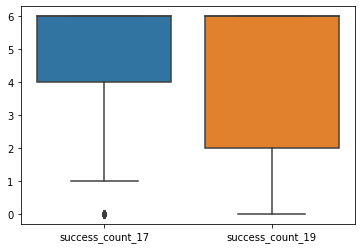

In [26]:
sns.boxplot(data=dtw2[['success_count_17', 'success_count_19']])

In [71]:
271/379

0.7150395778364116

In [27]:
dtw2[['success_count_17', 'success_count_19']].describe()

,success_count_17,success_count_19
count,379.000000,379.000000
mean,4.503958,4.298153
std,2.445568,2.501486
min,0.000000,0.000000
25%,4.000000,2.000000
50%,6.000000,6.000000
75%,6.000000,6.000000
max,6.000000,6.000000


In [26]:
dtw2['success_count_label'] = dtw2['success_count_17'] + dtw2['success_count_19']

/home/lmoraes/.pyenv/versions/machineteaching/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='success_count_label'>

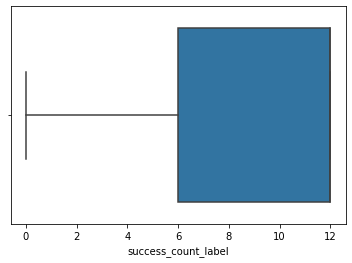

In [30]:
sns.boxplot(dtw2['success_count_label'])

In [31]:
dtw2['success_count_label'].describe()

count    379.000000
mean       8.802111
std        4.716895
min        0.000000
25%        6.000000
50%       12.000000
75%       12.000000
max       12.000000
Name: success_count_label, dtype: float64

In [32]:
dtw2[dtw2['success_count_label'] >= 6]

,attempts_12,success_rate_12,avg_timedelta_to_solution_12,avg_timedelta_from_beginning_12,on_time_exercises_12,frequency_12,success_count_12,attempts_13,success_rate_13,avg_timedelta_to_solution_13,...,frequency_19,success_count_19,attempts,success_rate,avg_timedelta_to_solution,avg_timedelta_from_beginning,on_time_exercises,frequency,success_count,success_count_label
910,8,0.375000,65.386857,328.720191,3,1,3,24,0.291667,291.476823,...,1,6,32,0.312500,223.649833,519.849833,10,2,10,12
911,4,0.750000,132.823499,684.156833,3,1,3,36,0.194444,23916.274449,...,2,6,40,0.250000,16781.239164,17381.439164,10,3,10,12
912,6,0.500000,24.270101,207.270101,3,1,3,7,1.000000,0.000000,...,1,6,13,0.769231,7.281030,141.581030,10,2,10,12
914,9,0.333333,430.621847,918.621847,3,1,3,91,0.076923,40044.526822,...,2,6,100,0.100000,28160.355329,28983.855329,10,4,10,12
915,8,0.375000,124.739469,243.072802,3,1,3,12,0.416667,18.759911,...,1,5,20,0.400000,58.502245,167.252245,8,2,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,0,NaN,NaN,NaN,0,0,0,10,0.100000,1289.224645,...,1,1,10,0.100000,NaN,NaN,0,1,1,7
1391,0,NaN,NaN,NaN,0,0,0,4,1.000000,0.000000,...,2,6,4,1.000000,NaN,NaN,0,1,4,12
1393,0,NaN,NaN,NaN,0,0,0,4,1.000000,0.000000,...,0,0,4,1.000000,NaN,NaN,0,1,4,6
1394,0,NaN,NaN,NaN,0,1,0,22,0.318182,579.336000,...,1,6,22,0.318182,NaN,NaN,0,1,7,12


In [49]:
dtw2.describe()

,attempts_12,success_rate_12,avg_timedelta_to_solution_12,avg_timedelta_from_beginning_12,on_time_exercises_12,frequency_12,success_count_12,attempts_13,success_rate_13,avg_timedelta_to_solution_13,...,frequency_19,success_count_19,attempts,success_rate,avg_timedelta_to_solution,avg_timedelta_from_beginning,on_time_exercises,frequency,success_count,success_count_label
count,379.000000,354.000000,3.360000e+02,3.360000e+02,379.000000,379.000000,379.000000,379.000000,357.000000,3.530000e+02,...,379.000000,379.000000,379.000000,379.000000,3.210000e+02,3.210000e+02,379.000000,379.000000,379.000000,379.000000
mean,17.744063,0.276748,5.585893e+04,5.775738e+04,2.047493,1.364116,2.490765,41.796834,0.302309,5.774606e+04,...,1.480211,4.298153,59.540897,0.252686,6.379628e+04,6.514594e+04,5.978892,3.488127,7.963061,8.802111
std,29.302210,0.223429,3.157869e+05,3.158571e+05,1.324520,0.812847,1.019282,54.363546,0.264249,1.368085e+05,...,1.211280,2.501486,74.024701,0.211998,1.787528e+05,1.787596e+05,3.773982,1.711072,2.887431,4.716895
min,0.000000,0.000000,0.000000e+00,2.800000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,1.000000,0.000000,0.000000e+00,9.009849e+01,0.000000,1.000000,0.000000,0.000000
25%,6.000000,0.107143,1.104425e+02,7.357762e+02,0.000000,1.000000,3.000000,11.500000,0.114754,3.689598e+02,...,1.000000,2.000000,22.000000,0.106383,6.739452e+02,1.539758e+03,3.000000,2.000000,7.000000,6.000000
50%,11.000000,0.222222,4.512617e+02,1.479540e+03,3.000000,1.000000,3.000000,23.000000,0.222222,4.805118e+03,...,1.000000,6.000000,38.000000,0.192308,8.823278e+03,1.036868e+04,7.000000,3.000000,10.000000,12.000000
75%,21.000000,0.375000,3.748889e+03,5.400861e+03,3.000000,2.000000,3.000000,50.500000,0.384615,3.967468e+04,...,2.000000,6.000000,71.000000,0.339080,5.507646e+04,5.670455e+04,10.000000,4.000000,10.000000,12.000000
max,439.000000,1.000000,4.853717e+06,4.853822e+06,3.000000,6.000000,3.000000,379.000000,1.000000,1.395349e+06,...,6.000000,6.000000,818.000000,1.000000,2.426880e+06,2.426952e+06,10.000000,12.000000,10.000000,12.000000


In [32]:
x = dtw2[['attempts_12', 'success_rate_12', 'avg_timedelta_to_solution_12',
       'avg_timedelta_from_beginning_12', 'on_time_exercises_12',
       'frequency_12', 'success_count_12', 'attempts_13', 'success_rate_13',
       'avg_timedelta_to_solution_13', 'avg_timedelta_from_beginning_13',
       'on_time_exercises_13', 'frequency_13', 'success_count_13']]
y = dtw2['success_count_label']

In [33]:
X = x.fillna(value={'success_rate_12': 0, 'success_rate_13': 0, 
                'avg_timedelta_to_solution_12': dtw2.max()['avg_timedelta_to_solution_12'],
                'avg_timedelta_from_beginning_12': dtw2.max()['avg_timedelta_from_beginning_12'],
                'avg_timedelta_to_solution_13': dtw2.max()['avg_timedelta_to_solution_13'],
                'avg_timedelta_from_beginning_13': dtw2.max()['avg_timedelta_from_beginning_13']
               })

In [34]:
df = dtw2.fillna(value={'success_rate_12': 0, 'success_rate_13': 0, 
                'avg_timedelta_to_solution_12': dtw2.max()['avg_timedelta_to_solution_12'],
                'avg_timedelta_from_beginning_12': dtw2.max()['avg_timedelta_from_beginning_12'],
                'avg_timedelta_to_solution_13': dtw2.max()['avg_timedelta_to_solution_13'],
                'avg_timedelta_from_beginning_13': dtw2.max()['avg_timedelta_from_beginning_13']
               })

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [63]:
model = LinearRegression().fit(X_train, y_train)

In [64]:
y_pred = model.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)

3.702164256180388

In [65]:
model.score(X, y)

0.38966014183825703

In [66]:
y_pred = model.predict(X_test)

In [67]:
mean_squared_error(y_test, y_pred, squared=False)

3.5911637103843277

Feature: attempts_12, Score: -0.00480
Feature: success_rate_12, Score: 1.08062
Feature: avg_timedelta_to_solution_12, Score: 0.00001
Feature: avg_timedelta_from_beginning_12, Score: -0.00001
Feature: on_time_exercises_12, Score: 0.70379
Feature: frequency_12, Score: -0.05427
Feature: success_count_12, Score: -0.73295
Feature: attempts_13, Score: -0.01279
Feature: success_rate_13, Score: -1.39718
Feature: avg_timedelta_to_solution_13, Score: 0.00011
Feature: avg_timedelta_from_beginning_13, Score: -0.00011
Feature: on_time_exercises_13, Score: 0.23302
Feature: frequency_13, Score: 0.38117
Feature: success_count_13, Score: 0.80040


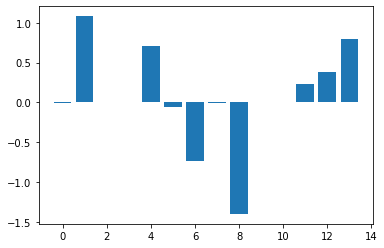

In [68]:
# get importance
importance = model.coef_
# summarize feature importance
columns = dtw2.columns
for i,v in enumerate(importance):
	print(f'Feature: {columns[i]}, Score: %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [24]:
%%R
library(gdata)
library(rattle)
library(rpart)
library(e1071)
library(tidyverse)
library(caret)

R[write to console]: gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

R[write to console]: 

R[write to console]: gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

R[write to console]: 
Attaching package: ‘gdata’


R[write to console]: The following object is masked from ‘package:stats’:

    nobs


R[write to console]: The following object is masked from ‘package:utils’:

    object.size


R[write to console]: The following object is masked from ‘package:base’:

    startsWith


R[write to console]: Loading required package: tibble

R[write to console]: Loading required package: bitops

R[write to console]: Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.

R[write to console]: ── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.3  

In [27]:
df = dtw2

In [87]:
%%R -i df

set.seed(84)
nrows <- nrow(df)
ntrain <- sample(nrows, round(nrows*0.8))
train <- df[ntrain,]
test_all <- df[-ntrain,]
test <- test_all %>% select(-success_count_label)
test_true <- test_all %>% select(success_count_label)
train_s <- train %>% select(-success_count_label)
train_true <- train %>% select(success_count_label)

# priors_false = c(0.6)
max_depth = c(2,3,4,5,6)
recall = c()
f1 = c()
acc = c()
params_prior = c()
params_maxdepth = c()
error = c()
for (md in max_depth){
#   for (p in priors_false) {
#     params_prior = c(params_prior, p)
    params_maxdepth = c(params_maxdepth, md)
#     p_true <- 1 - p
    control <- rpart.control(maxdepth=md)
    model = rpart(formula = success_count_label ~ attempts_12 + success_rate_12 + avg_timedelta_to_solution_12 + 
                  avg_timedelta_from_beginning_12 + on_time_exercises_12 + frequency_12 + success_count_12 + 
                  attempts_13 + success_rate_13 + avg_timedelta_to_solution_13 + avg_timedelta_from_beginning_13 + 
                  on_time_exercises_13 + frequency_13 + success_count_13, data = train, method='anova', 
                  control=control, 
                  parms = list(
#                       prior = c(p, p_true),
                               split = "gini"),
                  xval=10)
    # Prevendo no treino
    train_prediction <- predict(model, newdata=train_s)
    error <- c(error, RMSE(pred = train_prediction, obs = train_true$success_count_label))
#     train_prediction <- as.factor(as.logical(train_prediction))
#     train_true <- as.factor(as.logical(unlist(train_true)))
#     cm <- caret::confusionMatrix(train_prediction, train_true)
#     recall <- c(recall, cm$byClass[6])
#     acc <- c(acc, cm$overall[1])
#     f1 <- c(f1, cm$byClass[7])
#   }
};

print(error)
# print(recall)
# print(f1)
# print(acc)
# print(params_prior)
print(params_maxdepth)
# typeof(test_true$success_count_label)

[1] 3.776353 3.548675 3.337676 3.227211 3.189949
[1] 2 3 4 5 6


### Best models:
1. Prior = 0.6 (NOT COMPLETED) and 0.4 (COMPLETED)
2. Max depth = 3, 4 and 2

[1] 4.067425
      910       917       920       924       926       938       943       948 
11.348624 11.348624 11.348624  9.541667 11.348624 11.348624  9.541667  9.541667 
      956       957       959       960       966       972       974       979 
 6.025000 11.348624  6.025000  9.541667  6.025000 11.348624 11.348624 11.348624 
      986       987      1003      1007      1009      1014      1015      1016 
11.348624  9.541667  9.541667  6.025000 11.348624  9.541667  6.025000  9.541667 
     1025      1026      1032      1035      1036      1047      1052      1059 
 6.025000  9.541667 11.348624  9.541667 11.348624  9.541667  6.025000  6.025000 
     1060      1070      1081      1090      1107      1113      1116      1118 
11.348624  1.500000 11.348624 11.348624 11.348624  6.025000  9.541667  9.541667 
     1124      1141      1146      1156      1159      1173      1185      1196 
11.348624  9.541667  9.541667  6.025000 11.348624 11.348624  6.025000  9.541667 
     1201      

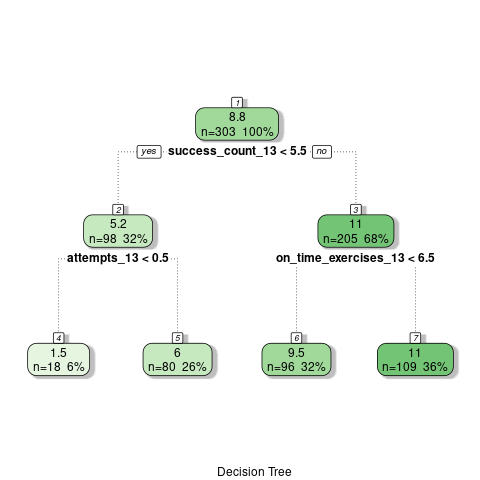

In [106]:
%%R -o cm

set.seed(84)
nrows <- nrow(df)
ntrain <- sample(nrows, round(nrows*0.8))
train <- df[ntrain,]
test_all <- df[-ntrain,]
test <- test_all %>% select(-success_count_label)
test_true <- test_all %>% select(success_count_label)
train_s <- train %>% select(-success_count_label)
train_true <- train %>% select(success_count_label)

control <- rpart.control(maxdepth=2)
model = rpart(formula = success_count_label ~ attempts_12 + success_rate_12 + avg_timedelta_to_solution_12 + 
                  avg_timedelta_from_beginning_12 + on_time_exercises_12 + frequency_12 + success_count_12 + 
                  attempts_13 + success_rate_13 + avg_timedelta_to_solution_13 + avg_timedelta_from_beginning_13 + 
                  on_time_exercises_13 + frequency_13 + success_count_13, data = train, method='anova', 
                  control=control, 
                  parms = list(
#                       prior = c(p, p_true), 
                      split = "gini"),
                  xval=10)

fancyRpartPlot(model,sub="Decision Tree")

# # Prevendo no teste
test_prediction <- predict(model, newdata=test)
error <- RMSE(pred = test_prediction, obs = test_true$success_count_label)

# test_prediction <- as.factor(as.logical(test_prediction))
# test_true <- as.factor(as.logical(unlist(test_true)))
# cm <- caret::confusionMatrix(test_prediction, test_true)
# print(cm)
# print(cm$byClass)
# print(cm$byClass[6])
# print(cm$overall[1])
# print(cm$byClass[7])
print(error)
print(test_prediction)

In [69]:
%%R -i df

set.seed(3213)
nrows <- nrow(df)
ntrain <- sample(nrows, round(nrows*0.8))
train <- df[ntrain,]
test_all <- df[-ntrain,]
test <- test_all %>% select(-success_count_label)
test_true <- test_all %>% select(success_count_label)
train_s <- train %>% select(-success_count_label)
train_true <- train %>% select(success_count_label)

model <- lm(formula = success_count_label ~ attempts_12 + success_rate_12 + avg_timedelta_to_solution_12 + 
                  avg_timedelta_from_beginning_12 + on_time_exercises_12 + frequency_12 + success_count_12 + 
                  attempts_13 + success_rate_13 + avg_timedelta_to_solution_13 + avg_timedelta_from_beginning_13 + 
                  on_time_exercises_13 + frequency_13 + success_count_13, data = train)

train_prediction <- predict(model, newdata=train_s)
error <- RMSE(pred = train_prediction, obs = train_true$success_count_label)

print(error)
summary(model)

[1] 3.594353

Call:
lm(formula = success_count_label ~ attempts_12 + success_rate_12 + 
    avg_timedelta_to_solution_12 + avg_timedelta_from_beginning_12 + 
    on_time_exercises_12 + frequency_12 + success_count_12 + 
    attempts_13 + success_rate_13 + avg_timedelta_to_solution_13 + 
    avg_timedelta_from_beginning_13 + on_time_exercises_13 + 
    frequency_13 + success_count_13, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.8020  -1.3451   0.5955   1.8801   9.6133 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      4.110e+00  1.484e+00   2.770  0.00597 ** 
attempts_12                     -1.998e-02  9.406e-03  -2.124  0.03455 *  
success_rate_12                  5.896e-01  1.204e+00   0.490  0.62468    
avg_timedelta_to_solution_12     1.145e-05  1.488e-05   0.769  0.44232    
avg_timedelta_from_beginning_12 -1.160e-05  1.491e-05  -0.778  0.43733    
on_time_exercises_12          

In [71]:
%%R
test_prediction <- predict(model, newdata=test)
error <- RMSE(pred = test_prediction, obs = test_true$success_count_label)

print(error)
# summary(model)
test_prediction

[1] 3.911306
       912        915        917        921        930        937        940 
11.5590669  9.3320281 11.3416474  7.6113930 11.6334794 11.0395323 11.5138472 
       959        961        966        968        974        975        976 
 6.9438608  9.7282058  4.1470435 10.6109285 11.1170431  8.5159592  4.9035242 
       977        988       1002       1004       1014       1015       1017 
11.4874616  9.1871746  9.8289650 10.5485624  9.6408959  2.6592333 11.8195124 
      1034       1049       1056       1061       1063       1065       1071 
 9.5871145  3.5116246 11.7121818 10.9886188 10.8261191 10.1857634  9.8989435 
      1072       1081       1088       1095       1101       1108       1111 
 5.5551056 11.4703413  4.4691467  7.9193362  2.4067183  9.5189158  2.2173921 
      1118       1144       1146       1149       1150       1152       1160 
 8.9042093 11.6577110  9.5796052 11.6299972  8.4532006  4.1266903 10.9339629 
      1168       1183       1184       1187       1

In [ ]:
from sklearn import metrics

In [162]:
avg_suc = df.mean()['success_rate_3']
def pred(row):
    if row['success_rate_3'] >= avg_suc:
        return True
    return False
pred_value = test_all.apply(pred, axis=1)

print(metrics.confusion_matrix(test_all['label'], pred_value))
print("F1: %.2f" % metrics.f1_score(test_all['label'], pred_value))
print("Acc: %.2f" % metrics.accuracy_score(test_all['label'], pred_value))
print("Recall: %.2f" %  metrics.recall_score(test_all['label'], pred_value))

[[19  5]
 [ 5  7]]
F1: 0.58
Acc: 0.72
Recall: 0.58


In [163]:
def pred(row):
    if row['success_rate_3'] >= 0.39:
        return True
    return False
pred_value = test_all.apply(pred, axis=1)

print(metrics.confusion_matrix(test_all['label'], pred_value))
print("F1: %.2f" % metrics.f1_score(test_all['label'], pred_value))
print("Acc: %.2f" % metrics.accuracy_score(test_all['label'], pred_value))
print("Recall: %.2f" %  metrics.recall_score(test_all['label'], pred_value))

[[22  2]
 [ 5  7]]
F1: 0.67
Acc: 0.81
Recall: 0.58
